# MLP (Multilayer perceptron) による画像の分類

Based on https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99

## Library の読み込み

In [1]:
import numpy as np # linear algebra
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.
/home/atsu/anaconda3/envs/Python3_6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/atsu/anaconda3/envs/Python3_6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/atsu/anaconda3/envs/Python3_6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/atsu/anacon

In [3]:
import tensorflow as tf
print(tf.__version__)

1.14.0


ファイル関連定数

In [3]:
train_file = "./data/train.csv"
test_file = "./data/test.csv"
output_file = "mlp_keras.csv"

## データの読み込みと前処理

NumPyを使ってCSVファイルを読み込みます。（Pandasでもできますが、今回はNumpyの行列でデータを扱うので Numpy に統一しました）

In [4]:
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',') # 先頭行は読み込まない

In [5]:
raw_data # numpy array を表示

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [7, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [9, 0, 0, ..., 0, 0, 0]])

In [6]:
raw_data.shape # pd,shape と同様に、np.shale もある

(42000, 785)

In [7]:
raw_data[np.isnan(raw_data)] # 欠損値がないことを確認 ※ 欠損値の処理は pabndas の方が簡単

array([], dtype=int64)

scikit-learn の train_test_split() 関数を使って、訓練用のデータと検証用のデータに分ける

In [8]:
x_train, x_val, y_train, y_val = train_test_split(raw_data[:,1:], raw_data[:,0], test_size=0.1)

In [9]:
print("x_train:", x_train.shape)
print("x_val:", x_val.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)

x_train: (37800, 784)
x_val: (4200, 784)
y_train: (37800,)
y_val: (4200,)


最初の４０個のデータを白黒画像で表示

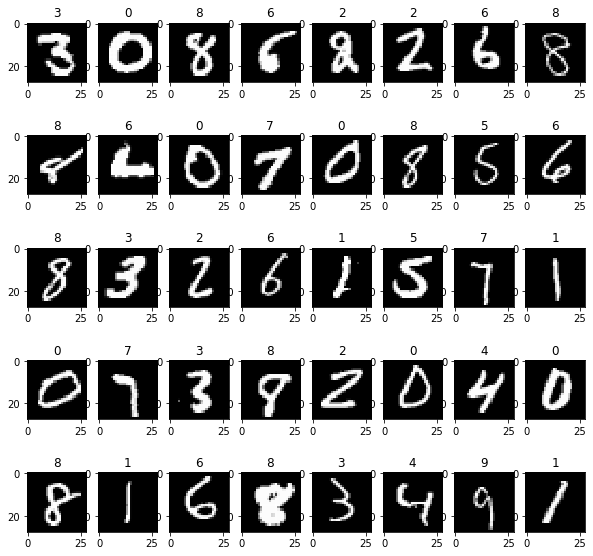

In [10]:
labels = ["0","1","2","3","4","5","6","7","8","9"]

plt.figure(figsize=(10, 10))
for i in range(0, 40):
    im = x_train[i].reshape(28,28)
    plt.subplot(5, 8, i + 1)
    plt.title(labels[y_train[i]])
    plt.tick_params(labelbottom="off",bottom="off") # x軸をオフ
    plt.tick_params(labelleft="off",left="off") # y軸をオフ
    plt.imshow(im, cmap='gray')

plt.show()

It would be possible to train the net on the original data, with pixel values 0 to 255. If we use the standard initialization methods for weights, however, data between 0 and 1 should make the net converge faster. 

In [11]:
# 値域の変換 [0-255] -> [0.0-1.0]
x_train = x_train.astype("float32")/255.
x_val = x_val.astype("float32")/255.

In [12]:
x_train[100]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

The labels were given as integers between 0 and 9. We need to convert these to one-hot encoding, i.e. a 10x1 array with one 1 and nine 0:s, with the position of the 1 showing us the value. See the example, with the position of the 1 showing the correct value for the digit in the graph above.

In [13]:
# ラベルデータをOne-Hot形式に変換
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


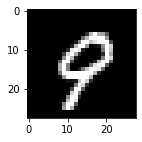

In [14]:
# example:
print(y_train[100])
fig, ax = plt.subplots(1, 1, figsize=(2,2))
plt.imshow(x_train[100].reshape(28,28), cmap='gray')

## モデルの作成と学習

Keras offers two different ways of defining a network. We will use the Sequential API, where you just add on one layer at a time, starting from the input.

In [15]:
# モデルを定義
model = Sequential()
model.add(Dense(512, input_shape=(784,))) # Dim(batch_size, input_dim) --> https://keras.io/ja/layers/core/#dense
model.add(Activation("relu"))
model.add(Dense(512))
model.add(Activation("relu"))
model.add(Dropout(rate=0.25))   # ドロップアウト：過学習を防ぎモデルの精度を上げる方法の一つ
model.add(Dense(10))  # 出力層；目的変数の分類数
model.add(Activation("softmax")) 





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [16]:
# 学習の前に、モデル構造を確認
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total para

The model needs to be compiled before training can start. As our loss function, we use logloss which is called ''categorical_crossentropy" in Keras. Metrics is only used for evaluation. As optimizer, we could have used ordinary stochastic gradient descent (SGD), but Adam is faster.

In [17]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

We train once with a smaller learning rate to ensure convergence. We then speed things up, only to reduce the learning rate by 10% every epoch. Keras has a function for this: 

In [18]:
hist = model.fit(x_train, y_train, 
                 validation_data=(x_val, y_val), 
                 batch_size=16, 
                 verbose=1,  # 0 = 表示なし，1 = プログレスバー，2 = 各試行毎に一行の出力．
                 epochs=3)

# モデルを保存
model.save_weights('mlp_keras.hdf5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 37800 samples, validate on 4200 samples
Epoch 1/3
37800/37800 [==============================] - 126s 3ms/step - loss: 0.3840 - acc: 0.8932 - val_loss: 0.1986 - val_acc: 0.9410
Epoch 2/3
37800/37800 [==============================] - 98s 3ms/step - loss: 0.1569 - acc: 0.9542 - val_loss: 0.1390 - val_acc: 0.9560
Epoch 3/3
37800/37800 [==============================] - 86s 2ms/step - loss: 0.1070 - acc: 0.9686 - val_loss: 0.1123 - val_acc: 0.9662


## 評価

In [19]:
# 学習済みのモデルを取得
# model.load_weights('mlp_keras.hdf5')

In [20]:
# 精度の評価
scores = model.evaluate(x_val, y_val, verbose=1)
print('Validation loss: {0:.4f}'.format(scores[0]))
print('Validation accuracy: {0:.4f}'.format(scores[1]))

4200/4200 [==============================] - 1s 224us/step
Validation loss: 0.1123
Validation accuracy: 0.9662


In [21]:
# 学習プロセスのプロット用関数

def Learning_Process_Plot(hist):
    acc = hist.history['acc'] # tf2.x: accuracy
    val_acc = hist.history['val_acc'] # tf2.x: val_accuracy
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, label='Training acc', ls="-", marker="o")
    plt.plot(epochs, val_acc, label='Validation acc', ls="-", marker="x")
    plt.title('Training and validation accuracy')
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(loc="best")

    plt.figure()

    plt.plot(epochs, loss, label='Training loss', ls="-", marker="o")
    plt.plot(epochs, val_loss, label='Validation loss', ls="-", marker="x")
    plt.title('Training and validation loss')
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(loc="best")

    plt.show()

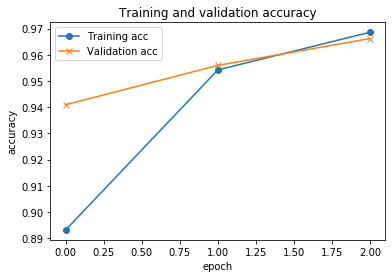

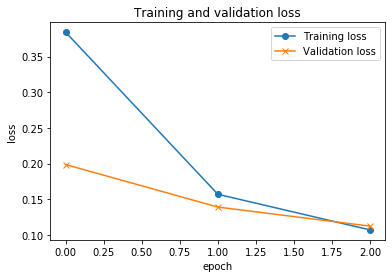

In [22]:
# 学習プロセスのプロット
Learning_Process_Plot(hist)

学習プロセスのプロットにより、過学習が起こり、Validation loss が増えていることが分かる

In [23]:
y_hat = model.predict(x_val)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[379   0   0   0   0   0   0   1   3   1]
 [  0 453   4   5   0   0   0   0   4   0]
 [  0   0 444   2   0   0   0   3   3   0]
 [  0   0   4 426   0   5   0   3   3   3]
 [  0   1   1   1 389   0   2   1   1  14]
 [  3   1   0   3   1 336   1   0   2   3]
 [  2   0   1   0   2   6 413   0   2   0]
 [  0   2   4   2   1   0   0 428   0   8]
 [  1   0   0   9   1   2   0   1 399   3]
 [  2   1   0   3   3   3   0   3   1 391]]


In [24]:
from sklearn.metrics import classification_report

labels = ["0","1","2","3","4","5","6","7","8","9"]

# Generate a classification report
report = classification_report(y_pred, y_true, target_names=labels)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       387
           1       0.97      0.99      0.98       458
           2       0.98      0.97      0.98       458
           3       0.96      0.94      0.95       451
           4       0.95      0.98      0.96       397
           5       0.96      0.95      0.96       352
           6       0.97      0.99      0.98       416
           7       0.96      0.97      0.97       440
           8       0.96      0.95      0.96       418
           9       0.96      0.92      0.94       423

    accuracy                           0.97      4200
   macro avg       0.97      0.97      0.97      4200
weighted avg       0.97      0.97      0.97      4200



## Submit

テストデータの読み込み

In [25]:
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype("float32")

学習したモデルを用いて予測

In [26]:
y_pred = model.predict(x_test, batch_size=64)
y_pred

array([[0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [27]:
y_pred = np.argmax(y_pred,axis=1) # One-hot データを分類データに変換
y_pred

array([2, 0, 9, ..., 3, 9, 2])

提出用CSVファイルの作成

In [28]:
with open(output_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))